In [1]:
# Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

Using transformers version: 4.57.3
Using datasets version: 4.4.1
Using torch version: 2.9.0+cu126


In [ ]:
# Load the dataset from Hugging Face Hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# Inspect the dataset
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [ ]:
dataset.column_names

{'train': ['text', 'label']}

In [ ]:
dataset.get("train")

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [ ]:
dataset.get("train")[0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

In [ ]:
import random

random_indexs = random.sample(range(len(dataset["train"])), 5)
random_samples = dataset["train"][random_indexs]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples["text"], random_samples["label"]):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: Vintage record player spinning a vinyl record | Label: not_food
Text: Set of paintbrushes stored in a jar | Label: not_food
Text: Colorful area rug brightening up a living room | Label: not_food
Text: Wooden dresser with a mirror reflecting the room | Label: not_food
Text: A steaming bowl of fiery chicken curry, infused with a blend of aromatic spices and topped with fresh cilantro leaves. | Label: food


In [ ]:
# Get unique label values
dataset["train"].unique("label")

['food', 'not_food']

In [ ]:
# Check number of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 125, 'not_food': 125})

In [ ]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset["train"])
food_not_food_df.sample(7)

,text,label
194,Set of wine glasses hanging on a rack,not_food
31,"Potatoes, onions, garlic, cauliflower, and bro...",food
218,"Mouthwatering mushroom curry, featuring shiita...",food
171,Red ceramic mug sitting next to a coffee maker,not_food
216,"Pizza with a unique crust, such as cauliflower...",food
183,Washing machine and dryer side by side in a la...,not_food
139,Swimming pool sparkling in a backyard,not_food


In [ ]:
# Create mapping from id2label and label2id
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


In [ ]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

example_sample = {"text": "This is a sentence about my favourite food: honey.", "label": "food"}

# Test the function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: honey.', 'label': 1}

In [ ]:
# Map our dataset labels to numbers
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [ ]:
# Shuffle the dataset and view the first 5 samples (will return different results each time)
dataset.shuffle()[:5]

{'text': ['Potted plant adding greenery to a windowsill',
  'A slice of pepperoni pizza with a layer of melted cheese',
  'A bowl of sliced mango with a drizzle of honey and a sprinkle of Tajin seasoning',
  'Cooking dinner in the kitchen, a man has a dog eagerly watching',
  'Drone resting on a desk'],
 'label': [0, 1, 1, 0, 0]}

In [ ]:
# Create train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42) # note: seed isn't needed, just here for reproducibility, without it you will get different splits each time you run the cell
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [ ]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset["train"][random_idx_train]

random_idx_test = random.randint(0, len(dataset["test"]))
random_sample_test = dataset["test"][random_idx_test]

print(f"[INFO] Random sample from training dataset:")
print(f"Text: {random_sample_train['text']}\nLabel: {random_sample_train['label']} ({id2label[random_sample_train['label']]})\n")
print(f"[INFO] Random sample from testing dataset:")
print(f"Text: {random_sample_test['text']}\nLabel: {random_sample_test['label']} ({id2label[random_sample_test['label']]})")

[INFO] Random sample from training dataset:
Text: A boy building a fort in the living room with his curious cat watching
Label: 0 (not_food)

[INFO] Random sample from testing dataset:
Text: A bowl of sliced bell peppers with a sprinkle of paprika and a side of hummus
Label: 1 (food)


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True) # uses fast tokenization (backed by tokenziers library and implemented in Rust) by default, if not available will default to Python implementation

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# Test out tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
# Try adding a "!" at the end
tokenizer("I love pizza!")

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
# Get the length of the vocabulary
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"Length of tokenizer vocabulary: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

Length of tokenizer vocabulary: 30522
Max tokenizer input sequence length: 512


In [ ]:
# Does "daniel" occur in the vocab?
tokenizer.vocab["dylan"]

7758

In [ ]:
tokenizer("akash")

{'input_ids': [101, 9875, 4095, 102], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer("akash").input_ids)

['[CLS]', 'aka', '##sh', '[SEP]']

In [ ]:
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True, # pad short sequences to longest sequence in the batch
                     truncation=True) # truncate long sequences to the maximum length the model can handle

In [ ]:
example_sample_2 = {"text": "I love pizza", "label": 1}

# Test the function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
# Map our tokenize_text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to operate across batches of examples rather than only single examples
                                batch_size=1000) # defaults to 1000, can be increased if you have a large dataset

tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [ ]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
# Create example list of predictions and labels
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


In [ ]:
from transformers import AutoModelForSequenceClassification

# Setup model for fine-tuning with classification head (top layers of network)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2, # can customize this to the number of classes in your dataset
    id2label=id2label, # mappings from class IDs to the class labels (for classification tasks)
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count the parameters of the model
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

In [ ]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

In [ ]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

# Create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch", # was previously "evaluation_strategy"
    save_strategy="epoch",
    save_total_limit=3, # limit the total amount of save checkpoints (so we don't save num_epochs checkpoints)
    use_cpu=False, # set to False by default, will use CUDA GPU or MPS device if available
    seed=42, # set to 42 by default for reproducibility
    load_best_model_at_end=True, # load the best model when finished training
    logging_strategy="epoch", # log training results every epoch
    report_to="none", # optional: log experiments to Weights & Biases/other similar experimenting tracking services (we'll turn this off for now)
    # push_to_hub=True # optional: automatically upload the model to the Hub (we'll do this manually later on)
    # hub_token="your_token_here" # optional: add your Hugging Face Hub token to push to the Hub (will default to huggingface-cli login)
    hub_private_repo=False # optional: make the uploaded model private (defaults to False)
)

[INFO] Saving model checkpoints to: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [ ]:
from transformers import Trainer

# Setup Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    # Note: the 'tokenizer' parameter will be changed to 'processing_class' in Transformers v5.0.0
    tokenizer=tokenizer, # Pass tokenizer to the Trainer for dynamic padding (padding as the training happens) (see "data_collator" in the Trainer docs)
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1457455194.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.348800,0.041301,1.000000
2,0.020400,0.005766,1.000000
3,0.004200,0.002147,1.000000
4,0.001800,0.001220,1.000000
5,0.001200,0.000864,1.000000
6,0.000900,0.000700,1.000000
7,0.000700,0.000614,1.000000
8,0.000700,0.000568,1.000000
9,0.000700,0.000543,1.000000
10,0.000600,0.000535,1.000000


In [ ]:
# Inspect training metrics
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 67.084
train_samples_per_second: 29.813
train_steps_per_second: 1.043
total_flos: 18110777160000.0
train_loss: 0.038010370332215514
epoch: 10.0


In [ ]:
# Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [ ]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics (we've seen these already)
trainer_history_training_time = trainer_history_all[-1] # this is the same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.3488,
  'grad_norm': 1.0228275060653687,
  'learning_rate': 9.142857142857143e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.041300758719444275,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.086,
  'eval_samples_per_second': 581.242,
  'eval_steps_per_second': 23.25,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0204,
  'grad_norm': 0.11275622248649597,
  'learning_rate': 8.142857142857143e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.005766055081039667,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0748,
  'eval_samples_per_second': 668.179,
  'eval_steps_per_second': 26.727,
  'epoch': 2.0,
  'step': 14}]

In [ ]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 1.0228275060653687,
  'learning_rate': 9.142857142857143e-05,
  'loss': 0.3488,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.11275622248649597,
  'learning_rate': 8.142857142857143e-05,
  'loss': 0.0204,
  'step': 14}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.041300758719444275,
  'eval_runtime': 0.086,
  'eval_samples_per_second': 581.242,
  'eval_steps_per_second': 23.25,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.005766055081039667,
  'eval_runtime': 0.0748,
  'eval_samples_per_second': 668.179,
  'eval_steps_per_second': 26.727,
  'step': 14}]


In [ ]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.3488,1.022828,0.000091,1.0,7
1,0.0204,0.112756,0.000081,2.0,14
2,0.0042,0.045375,0.000071,3.0,21
3,0.0018,0.026455,0.000061,4.0,28
4,0.0012,0.016862,0.000051,5.0,35


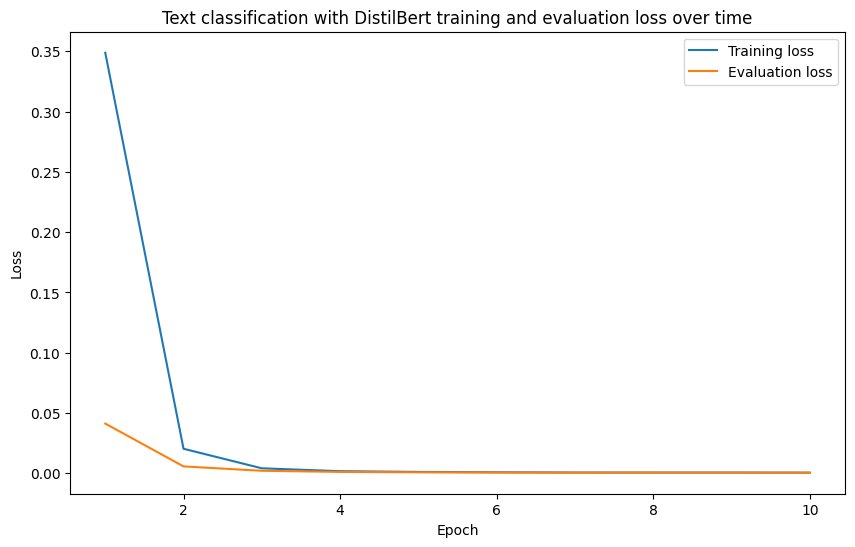

In [ ]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

In [ ]:
# Perform predictions on the test set
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
prediction_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.0005350745632313192,
 'test_accuracy': 1.0,
 'test_runtime': 0.1325,
 'test_samples_per_second': 377.384,
 'test_steps_per_second': 15.095}

In [ ]:
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities (this is optional, could get the same results with step 2 onwards)
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = dataset["test"]["label"]

# 4. Compare predicted labels to true labels to get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}%")

[INFO] Test accuracy: 100.0%


In [ ]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999420
1,Red brick fireplace with a mantel serving as a...,0,0,0.999574
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999424
3,Set of mugs hanging on a hook,0,0,0.999585
4,Standing floor lamp providing light next to an...,0,0,0.999580


In [ ]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
43,Set of muffin tins stacked together,0,0,0.999273
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999383
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.999388
26,A fruit platter with a variety of exotic fruit...,1,1,0.999410
41,"Sushi with a spicy kick, featuring jalapeno pe...",1,1,0.999411
20,"Pizza with a seafood theme, featuring toppings...",1,1,0.999412
44,Seasonal sushi roll with ingredients like pers...,1,1,0.999414
19,"Spicy chickpea curry bowl, featuring nutty chi...",1,1,0.999414
18,Traditional Japanese flavored sushi roll with ...,1,1,0.999414
14,Two handfuls of bananas in a fruit bowl with g...,1,1,0.999414


In [ ]:
def set_device():
    """
    Set device to CUDA if available, else MPS (Mac), else CPU.

    This defaults to using the best available device (usually).
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


In [ ]:
# Setup local model path
local_model_path = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"
huggingface_model_path = "dthunn/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

In [ ]:
import torch
from transformers import pipeline

# Set the batch size for predictions
BATCH_SIZE = 32

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task="text-classification", # we can use this because our model is an instance of AutoModelForSequenceClassification
                                    model=local_model_path, # could also pass in huggingface_model_path
                                    device=DEVICE, # set the target device
                                    top_k=1, # only return the top predicted value
                                    batch_size=BATCH_SIZE) # perform predictions on up to BATCH_SIZE number of samples at a time

food_not_food_classifier

Device set to use cuda


In [ ]:
# Test our trained model on some example text
sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"
food_not_food_classifier(sample_text_food)

[[{'label': 'food', 'score': 0.9993752837181091}]]

In [ ]:
# Test the model on some more example text
sample_text_not_food = "A yellow tractor driving over the hill"
food_not_food_classifier(sample_text_not_food)

[[{'label': 'not_food', 'score': 0.9995660185813904}]]

In [ ]:
# Pass in random text to the model
food_not_food_classifier("cvnhertiejhwgdjshdfgh394587")

[[{'label': 'not_food', 'score': 0.9986156225204468}]]

In [ ]:
# Create batch size (we don't need to do this again but we're doing it for clarity)
BATCH_SIZE = 32 # this number is experimental and will require testing on your hardware to find the optimal value (e.g. lower if there are memory issues or higher to try speed up inference)

# Setup pipeline to handle batches (we don't need to do this again either but we're doing it for clarity)
food_not_food_classifier = pipeline(task="text-classification",
                                    model=local_model_path,
                                    batch_size=BATCH_SIZE,
                                    device=DEVICE)

Device set to use cuda


In [ ]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[{'label': 'not_food', 'score': 0.9735151529312134},
 {'label': 'not_food', 'score': 0.9972350001335144},
 {'label': 'not_food', 'score': 0.9630624651908875},
 {'label': 'not_food', 'score': 0.9992628693580627},
 {'label': 'not_food', 'score': 0.9987456798553467},
 {'label': 'not_food', 'score': 0.9948937892913818},
 {'label': 'not_food', 'score': 0.8996883034706116},
 {'label': 'food', 'score': 0.9993330836296082},
 {'label': 'not_food', 'score': 0.999263346195221},
 {'label': 'food', 'score': 0.9860221147537231}]

In [ ]:
import time

# Create 1000 sentences
sentences_1000 = sentences * 100

# Time how long it takes to make predictions on all sentences (one at a time)
print(f"[INFO] Number of sentences: {len(sentences_1000)}")
start_time_one_at_a_time = time.time()
for sentence in sentences_1000:
    # Make a prediction on each sentence one at a time
    food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time()

print(f"[INFO] Time taken for one at a time prediction: {end_time_one_at_a_time - start_time_one_at_a_time} seconds")
print(f"[INFO] Avg inference time per sentence: {(end_time_one_at_a_time - start_time_one_at_a_time) / len(sentences_1000)} seconds")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[INFO] Number of sentences: 1000
[INFO] Time taken for one at a time prediction: 9.919434309005737 seconds
[INFO] Avg inference time per sentence: 0.009919434309005737 seconds


In [ ]:
for i in [10, 100, 1000, 10_000]:
    sentences_big = sentences * i
    print(f"[INFO] Number of sentences: {len(sentences_big)}")

    start_time = time.time()
    # Predict on all sentences in batches
    food_not_food_classifier(sentences_big)
    end_time = time.time()

    print(f"[INFO] Inference time for {len(sentences_big)} sentences: {round(end_time - start_time, 5)} seconds.")
    print(f"[INFO] Avg inference time per sentence: {round((end_time - start_time) / len(sentences_big), 8)} seconds.")
    print()

[INFO] Number of sentences: 100
[INFO] Inference time for 100 sentences: 0.23029 seconds.
[INFO] Avg inference time per sentence: 0.00230289 seconds.

[INFO] Number of sentences: 1000
[INFO] Inference time for 1000 sentences: 2.6687 seconds.
[INFO] Avg inference time per sentence: 0.0026687 seconds.

[INFO] Number of sentences: 10000
[INFO] Inference time for 10000 sentences: 13.82612 seconds.
[INFO] Avg inference time per sentence: 0.00138261 seconds.

[INFO] Number of sentences: 100000
[INFO] Inference time for 100000 sentences: 98.24779 seconds.
[INFO] Avg inference time per sentence: 0.00098248 seconds.



In [ ]:
from transformers import AutoTokenizer

# Setup model path (can be local or on Hugging Face)
model_path = "mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create an example to predict on
sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"

# Prepare the tokenizer and tokenize the inputs
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
inputs = tokenizer(sample_text_food,
                   return_tensors="pt") # return the output as PyTorch tensors
inputs

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997,  1037,  5127,  1997, 13501,  6763,
          1010, 11611,  1998, 15174,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
device = model.device  # gets cuda or cpu automatically

inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
# Get predicted class and prediction probability
predicted_class_id = outputs.logits.argmax().item()
prediction_probability = torch.softmax(outputs.logits, dim=1).max().item()

print(f"Text: {sample_text_food}")
print(f"Predicted label: {model.config.id2label[predicted_class_id]}")
print(f"Prediction probability: {prediction_probability}")

Text: A delicious photo of a plate of scrambled eggs, bacon and toast
Predicted label: food
Prediction probability: 0.9993752837181091


In [ ]:
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)

# Make sample text and tokenize it
sample_text = "A photo of a broccoli, salmon, rice and radish dish"
inputs = tokenizer(sample_text, return_tensors="pt")

# Make a prediction
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted class and prediction probability
output_logits = outputs.logits
predicted_class_id = torch.argmax(output_logits, dim=1).item()
predicted_class_label = model.config.id2label[predicted_class_id]
predicted_probability = torch.softmax(output_logits, dim=1).max().item()

# Print outputs
print(f"Text: {sample_text}")
print(f"Predicted class: {predicted_class_label} (prob: {predicted_probability * 100:.2f}%)")

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Text: A photo of a broccoli, salmon, rice and radish dish
Predicted class: food (prob: 99.94%)


In [3]:
# 1. Import necessary packages
import pprint
from pathlib import Path

import numpy as np
import torch

import datasets
import evaluate

from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 2. Setup variables for model training and saving pipeline
DATASET_NAME = "mrdbourke/learn_hf_food_not_food_image_captions"
MODEL_NAME = "distilbert/distilbert-base-uncased"
MODEL_SAVE_DIR_NAME = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# 3. Create a directory for saving models
# Note: This will override our existing saved model (if there is one)
print(f"[INFO] Creating directory for saving models: {MODEL_SAVE_DIR_NAME}")
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)

# 4. Load and preprocess the dataset from Hugging Face Hub
print(f"[INFO] Downloading dataset from Hugging Face Hub, name: {DATASET_NAME}")
dataset = datasets.load_dataset(path=DATASET_NAME)

# Create mappings from id2label and label2id (adjust these for your target dataset, can also create these programmatically)
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

# Create function to map IDs to labels in dataset
def map_labels_to_number(example):
    example["label"] = label2id[example["label"]]
    return example

# Map preprocessing function to dataset
dataset = dataset["train"].map(map_labels_to_number)

# Split the dataset into train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 5. Import a tokenizer and map it to our dataset
print(f"[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                          use_fast=True)

# Create a preprocessing function to tokenize text
def tokenize_text(examples):
    return tokenizer(examples["text"],
                     padding=True,
                     truncation=True)

tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)

# 6. Set up an evaluation metric & function to evaluate our model
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels):
    predictions, labels = predictions_and_labels

    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels) # note: use "references" parameter rather than "labels"


# 7. Import a model and prepare it for training
print(f"[INFO] Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)
print(f"[INFO] Model loading complete!")

# Setup TrainingArguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    push_to_hub=False,
    hub_private_repo=False # Note: if set to False, your model will be publically available
)

# Create Trainer instance and train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

# 8. Train the model on our text dataset
print(f"[INFO] Commencing model training...")
results = trainer.train()

# 9. Save the trained model (note: this will overwrite our previous model, this is ok)
print(f"[INFO] Model training complete, saving model to local path: {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

# 10. Push the model to the Hugging Face Hub
print(f"[INFO] Uploading model to Hugging Face Hub...")
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model"
)
print(f"[INFO] Model upload complete, model available at: {model_upload_url}")

# 11. Evaluate the model on the test data
print(f"[INFO] Performing evaluation on test dataset...")
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
pprint.pprint(prediction_metrics)

[INFO] Creating directory for saving models: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Downloading dataset from Hugging Face Hub, name: mrdbourke/learn_hf_food_not_food_image_captions


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

[INFO] Loading model: distilbert/distilbert-base-uncased


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Model loading complete!


/tmp/ipython-input-1806301120.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[INFO] Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.389300,0.057142,1.000000
2,0.029100,0.006597,1.000000
3,0.004700,0.002348,1.000000
4,0.002000,0.001324,1.000000
5,0.001300,0.000942,1.000000
6,0.001000,0.000765,1.000000
7,0.000900,0.000671,1.000000
8,0.000800,0.000619,1.000000
9,0.000700,0.000591,1.000000
10,0.000700,0.000582,1.000000


[INFO] Model training complete, saving model to local path: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Uploading model to Hugging Face Hub...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...uncased/model.safetensors:   5%|4         | 12.4MB /  268MB            

  ...uncased/training_args.bin:   2%|1         |   103B / 5.91kB            

[INFO] Model upload complete, model available at: https://huggingface.co/dthunn/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/
[INFO] Performing evaluation on test dataset...


[INFO] Prediction metrics on the test data:
{'test_accuracy': 1.0,
 'test_loss': 0.0005823588580824435,
 'test_runtime': 0.0905,
 'test_samples_per_second': 552.4,
 'test_steps_per_second': 22.096}


In [2]:
# Setup local model path
local_model_path = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Setup Hugging Face model path (see: https://huggingface.co/mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased)
# Note: Be sure to change "mrdbourke" to your own Hugging Face username
huggingface_model_path = "mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

In [4]:
from typing import Dict

# 1. Create a function which takes text as input
def food_not_food_classifier(text: str) -> Dict[str, float]:
    """
    Takes an input string of text and classifies it into food/not_food in the form of a dictionary.
    """

    # 2. Setup the pipeline to use the local model (or Hugging Face model path)
    food_not_food_classifier = pipeline(task="text-classification",
                                        model=local_model_path,
                                        batch_size=32,
                                        device="cuda" if torch.cuda.is_available() else "cpu", # set the device to work in any environment
                                        top_k=None) # return all possible scores (not just top-1)

    # 3. Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # 4. Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

# Test out the function
food_not_food_classifier("My lunch today was chicken and salad")

Device set to use cuda


{'food': 0.9991858601570129, 'not_food': 0.0008140744757838547}

In [5]:
# 1. Import Gradio as the common alias "gr"
import gradio as gr

# 2. Setup a Gradio interface to accept text and output labels
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
    title="Food or Not Food Classifier",
    description="A text classifier to determine if a sentence is about food or not food.",
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
              ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 3. Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://89a3dcab16e651d59b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
